In [2]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import segmentation_models_pytorch as smp

from skimage.morphology import skeletonize
from skimage.util import invert
import skimage as ski
from skimage.util import img_as_ubyte

from sklearn.model_selection import train_test_split

from PIL import Image
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


# Drive Mount

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

# Local Mount

Text(0.5, 1.0, 'skeleton')

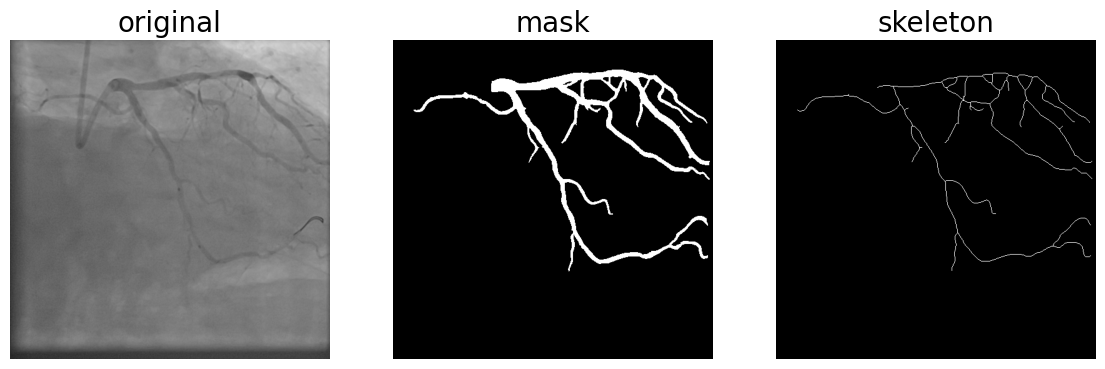

In [4]:
data_dir = './db/unet_1'

def readImages(dir):
    img_file = os.listdir(data_dir+'/img')
    label_file = os.listdir(data_dir+'/label')
    list = [ [], [] ]
    for img, label in zip(img_file, label_file):
        list[0].append(ski.io.imread(dir+'/img/'+img))
        list[1].append(ski.io.imread(dir+'/label/'+label))
    return list[0], list[1]
    
img, label = readImages(data_dir)

gray_image = ski.color.rgb2gray(label[0])
skeleton = skeletonize(gray_image)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,7), sharex=True, sharey=True)

axes[0].imshow(img[0])
axes[0].axis('off')
axes[0].set_title('original', fontsize=20)

axes[1].imshow(label[0], cmap=plt.cm.gray)
axes[1].axis('off')
axes[1].set_title('mask', fontsize=20)

axes[2].imshow(skeleton, cmap=plt.cm.gray)
axes[2].axis('off')
axes[2].set_title('skeleton', fontsize=20)


# Dataset Class

In [6]:
class UnetDataset(Dataset):

    def __init__(self, img_dir, label_dir, names , transform=None, label_transform=None, preprocessing=None):
        super().__init__()
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.names = names
        self.transform = transform
        self.label_transform=label_transform
        self.preprocessing=preprocessing

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.names[idx])
        label_path = os.path.join(self.label_dir, self.names[idx])
        image = Image.open(img_path).convert("RGB")
        label = np.array(Image.open(label_path).convert("L"), dtype=np.float32)
        label[label == 255.0] = 1.0
        label = Image.fromarray(label)


        if self.transform:
            image = self.transform(image)

        if self.label_transform:
            label = self.label_transform(label)
        if self.preprocessing:
            image, label = self.preprocessing(image, label)

        return image, label
    

# Data split

In [ ]:
data_dir = './drive/MyDrive/unet'

In [9]:
data_dir = './db/unet_1'

In [11]:
torch.manual_seed(42)
names = os.listdir(data_dir+'/label_skeleton')
img_dir = os.path.join(data_dir, 'img')
label_dir = os.path.join(data_dir, 'label_skeleton')
X_train, X_test = train_test_split(names, test_size=0.1, random_state=42)
X_train, X_val = train_test_split(X_train, test_size=len(X_test), random_state=42)

print(f"Training : { len(X_train) }")
print(f"Test : { len(X_test) }")
print(f"Validation : { len(X_val) }\n")

img_transforms = transforms.Compose([
    #transforms.Resize(224),
    #transforms.CenterCrop(224),
    ToTensor(),
])

label_transform = transforms.Compose([
	#transforms.Resize(224),
	#transforms.CenterCrop(224),
	ToTensor(),
])

train_dataset = UnetDataset(img_dir, label_dir, X_train, transform=img_transforms, label_transform=label_transform, preprocessing=preprocessing)
test_dataset = UnetDataset(img_dir, label_dir, X_test, transform = img_transforms, label_transform=label_transform, preprocessing=preprocessing)
val_dataset = UnetDataset(img_dir, label_dir, X_val, transform = img_transforms, label_transform=label_transform, preprocessing=preprocessing)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

img1, label1 = train_dataset[0]

print(img1)
print(label1)

Training : 421
Test : 53
Validation : 53

tensor([[[0.2784, 0.2627, 0.2549,  ..., 0.5804, 0.5843, 0.5608],
         [0.2784, 0.2745, 0.2510,  ..., 0.5804, 0.5765, 0.5647],
         [0.2706, 0.2824, 0.2588,  ..., 0.5529, 0.5373, 0.5373],
         ...,
         [0.2627, 0.2863, 0.2941,  ..., 0.2902, 0.2824, 0.2627],
         [0.2627, 0.2745, 0.2745,  ..., 0.3059, 0.2824, 0.2510],
         [0.2431, 0.2510, 0.2510,  ..., 0.3176, 0.2824, 0.2627]],

        [[0.2784, 0.2627, 0.2549,  ..., 0.5804, 0.5843, 0.5608],
         [0.2784, 0.2745, 0.2510,  ..., 0.5804, 0.5765, 0.5647],
         [0.2706, 0.2824, 0.2588,  ..., 0.5529, 0.5373, 0.5373],
         ...,
         [0.2627, 0.2863, 0.2941,  ..., 0.2902, 0.2824, 0.2627],
         [0.2627, 0.2745, 0.2745,  ..., 0.3059, 0.2824, 0.2510],
         [0.2431, 0.2510, 0.2510,  ..., 0.3176, 0.2824, 0.2627]],

        [[0.2784, 0.2627, 0.2549,  ..., 0.5804, 0.5843, 0.5608],
         [0.2784, 0.2745, 0.2510,  ..., 0.5804, 0.5765, 0.5647],
         [0.2706

Text(0.5, 1.0, 'mask')

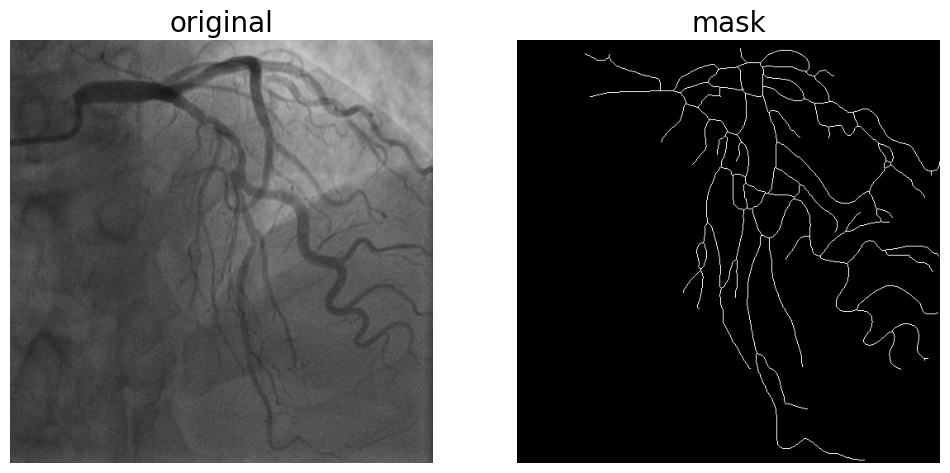

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6), sharex=True, sharey=True)

axes[0].imshow(img1.permute(1,2,0))
axes[0].axis('off')
axes[0].set_title('original', fontsize=20)

axes[1].imshow(label1.permute(1,2,0), cmap=plt.cm.gray)
axes[1].axis('off')
axes[1].set_title('mask', fontsize=20)



# Metrics

- F1 score
- Accuracy
- Presicion
- IoU
- Recall

In [74]:
def metrics(model, loader, criterion, device):
    iou_score = 0
    f1_score = 0
    accuracy = 0
    recall = 0
    precision = 0
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in loader:
            X, y = X.float().to(device), y.float().to(device)
            preds = model(X)
            total_loss += criterion(preds, y).item()

            tp, fp, tn, fn = smp.metrics.get_stats(preds, y, mode="binary", threshold=0.5)
            iou_score += smp.metrics.iou_score(tp, fp, tn, fn, reduction="micro")
            f1_score += smp.metrics.f1_score(tp, fp, tn, fn, reduction="micro")
            accuracy += smp.metrics.accuracy(tp, fp, tn, fn, reduction="macro")
            recall += smp.metrics.recall(tp, fp, tn, fn, reduction="micro-imagewise")
            precision += smp.metrics.precision(tp, fp, tn, fn, reduction="macro")

    batch_count = len(loader)
    return (
        total_loss / batch_count,
        iou_score / batch_count,
        f1_score / batch_count,
        accuracy / batch_count,
        recall / batch_count,
        precision / batch_count,
    )
    

# Train

In [77]:
def save_data(model_name: str, epochs: int, train_losses, val_losses, accuracy, recall, precision, f1_score, iou):
    model_path = f"./results/{model_name}.csv"
    os.makedirs("./results", exist_ok=True)

    new_data = pd.DataFrame.from_dict({
        'epoch': list(range(1, epochs + 1)),
        'train_loss': train_losses,
        'val_loss': val_losses,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'iou': iou
    })

    if os.path.exists(model_path):
        results = pd.read_csv(model_path)
        results = pd.concat([results, new_data], ignore_index=True)
    else:
        results = new_data

    results.to_csv(model_path, index=False)


In [79]:
def train(model_type: str, model, criterion, optimizer, train_loader, val_loader, epochs: int, device: str):
    train_losses = []
    val_losses = []
    accuracy_total = []
    recall_total = []
    precision_total = []
    f1_score_total = []
    iou_total = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for b, (X_train, y_train) in enumerate(train_loader):
            X_train, y_train = X_train.float().to(device), y_train.float().to(device)

            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        val_loss, iou_score, f1_score, accuracy, recall, precision = metrics(
            model, val_loader, criterion, device
        )
        val_losses.append(val_loss)
        accuracy_total.append(accuracy)
        recall_total.append(recall)
        precision_total.append(precision)
        f1_score_total.append(f1_score)
        iou_total.append(iou_score)

        print(
            f"Epoch {epoch+1}/{epochs} | Train Loss: {train_losses[-1]:.4f} | "
            f"Val Loss: {val_loss:.4f} | IoU: {iou_score:.4f} | "
            f"Precision: {precision:.4f} | Recall: {recall:.4f} | "
            f"F1 Score: {f1_score:.4f}"
        )

    save_data(
        model_type, epochs, train_losses, val_losses,
        accuracy_total, recall_total, precision_total,
        f1_score_total, iou_total
    )


# Config

In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 25

# U-Net w/ Resnet34 imagnet Backbone

## Test

In [86]:
unet = smp.Unet('resnet34', encoder_weights='imagenet')

In [87]:
x = torch.rand((1,3,512,512))
y = unet(x)
print(y)

tensor([[[[ 1.0162,  0.4892,  0.6568,  ...,  0.1498,  0.9385,  0.1043],
          [ 0.9885,  0.2854,  0.8288,  ...,  0.7941,  0.8776,  0.5370],
          [ 0.8577,  0.0198,  0.0912,  ...,  0.0525,  0.1859, -0.4823],
          ...,
          [ 0.9538,  0.0039, -0.7345,  ...,  1.5246,  1.5861,  0.1866],
          [ 1.6006,  0.7160, -0.0040,  ...,  0.0426,  0.6518,  0.4869],
          [-0.1060, -0.1427,  0.0192,  ..., -0.6510,  0.4379, -0.0382]]]],
       grad_fn=<ConvolutionBackward0>)


## Training

In [ ]:
unet = smp.Unet('resnet34', encoder_weights='imagenet')
criterion = smp.losses.FocalLoss(mode='binary')
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)
train('unet', unet, criterion, optimizer, train_loader, val_loader, epochs, device)
save_model(unet, "unet_resnet34")